In [1]:
import os
import time
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
from matplotlib import pyplot as plt
from torch.utils.tensorboard import SummaryWriter


# Download the data from huggingface (https://huggingface.co/datasets/simbaswe/galah4/tree/main)
# Then, specify this directory here
DATA_PATH = '/Users/jonathan/Documents/Homeworks_with_Python/Adv. Deep Learning/Ex1_Astronomy/data/galah4'


# Select the gpu device if available
if torch.cuda.is_available():
    device = torch.device("cuda")       #CUDA GPU
elif torch.backends.mps.is_available():
    device = torch.device("mps")        #Apple GPU
else:
    device = torch.device("cpu")        #if nothing is found use the CPU
print(f"Using device: {device}")

Using device: mps


In [62]:
# Load the data and labels
# spectra: 2D array of spectra with shape (n_spectra, n_pixels)
# labels: 2D array of labels with shape (n_spectra, n_labels)
# labelNames: list of strings with the names of the labels
spectra = np.load(f"{DATA_PATH}/spectra.npy")
n_spectra = spectra.shape[0]
n_channels = spectra.shape[1]
# labels: mass, age, l_bol, dist, t_eff, log_g, fe_h, SNR
labelNames = ["mass", "age", "l_bol", "dist", "t_eff", "log_g", "fe_h", "SNR"]
labels = np.load(f"{DATA_PATH}/labels.npy")
# We only use the three labels: t_eff, log_g, fe_h, SNR
labelNames = labelNames[-4:-1]
labels = labels[:, -4:-1]
n_labels = labels.shape[1]

# normalize the spectra
spectra = np.log(np.maximum(spectra, 0.2))
# normalize the labels
labels_std = labels.std(axis=0)
labels_mean = labels.mean(axis=0)
labels = (labels - labels_mean) / labels_std

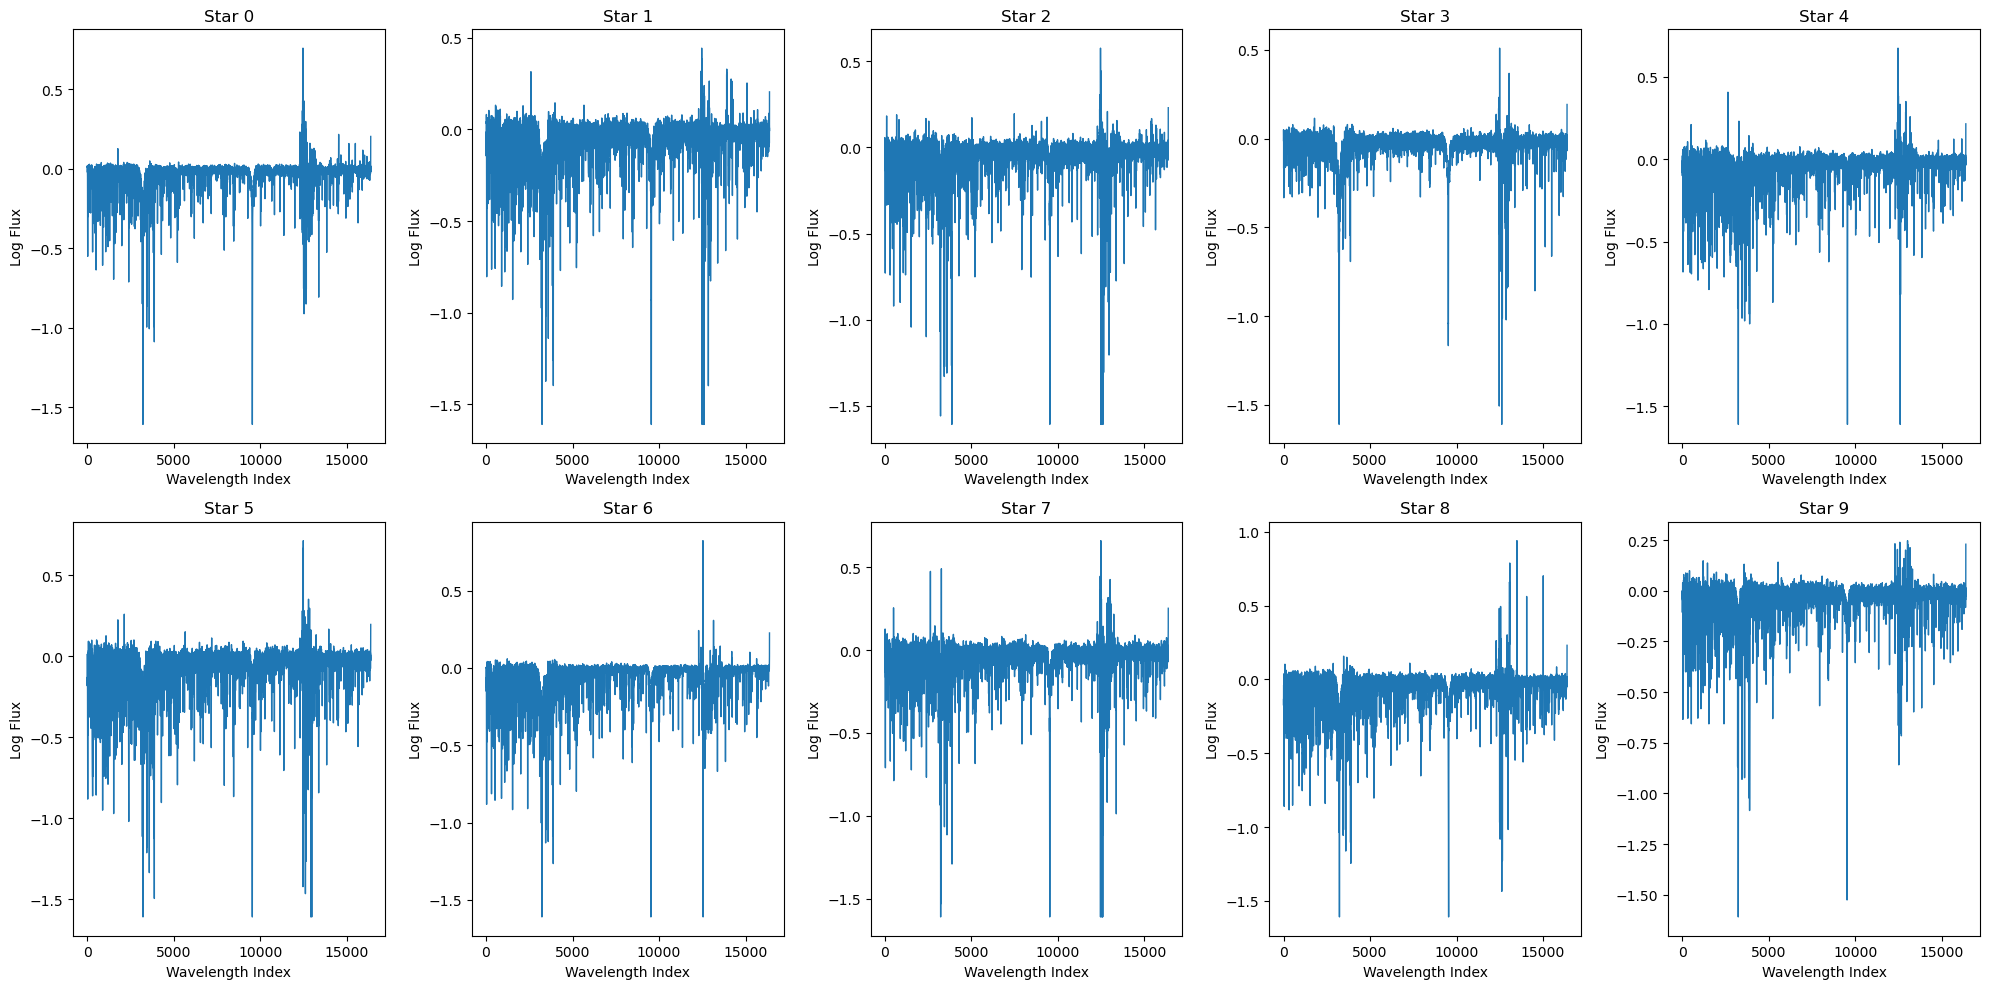

In [3]:
# plot a few spectra in a multiplot
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 2 rows, 5 columns
for i, ax in enumerate(axes.flatten()):
  ax.plot(spectra[i], lw=1)
  ax.set_title(f"Star {i}")
  ax.set_xlabel("Wavelength Index")
  ax.set_ylabel("Log Flux")
plt.tight_layout()
plt.savefig('/Users/jonathan/Documents/Homeworks_with_Python/Adv. Deep Learning/Ex1_Astronomy/graphics/spectra.png',bbox_inches='tight')

In [43]:
# Define a custom Dataset class
class CustomDataset(TensorDataset):
    """
    A custom dataset class for handling input features and labels.

    This class is designed to work with PyTorch's DataLoader and provides
    functionality to access input features and corresponding labels by index.

    Parameters
    ----------
    X : torch.Tensor
        A tensor containing the input features.
    y : torch.Tensor
        A tensor containing the labels corresponding to the input features.

    Methods
    -------
    __len__()
        Returns the number of samples in the dataset.
    __getitem__(idx)
        Retrieves the input features and label at the specified index.

    Examples
    --------
    >>> from torch.utils.data import DataLoader
    >>> dataset = CustomDataset(X=torch.randn(100, 10), y=torch.randint(0, 2, (100,)))
    >>> dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
    >>> for batch_X, batch_y in dataloader:
    ...     print(batch_X.shape, batch_y.shape)
    """
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

    #def load_files:
    #  ...


In [ ]:
class BigCNN(nn.Module):
    """
    A deep convolutional neural network (CNN) for regression tasks.

    This class defines a CNN architecture with multiple convolutional, 
    pooling, and fully connected layers. It is designed to process 
    1D input data and output predictions for regression tasks.

    Attributes
    ----------
    layer1 : nn.Conv1d
        The first convolutional layer with 32 output channels.
    batchnorm1 : nn.BatchNorm1d
        Batch normalization for the first convolutional layer.
    relu1 : nn.ReLU
        ReLU activation function for the first layer.
    pooling1 : nn.MaxPool1d
        Max pooling layer after the first convolutional layer.
    layer2 : nn.Conv1d
        The second convolutional layer with 64 output channels.
    batchnorm2 : nn.BatchNorm1d
        Batch normalization for the second convolutional layer.
    relu2 : nn.ReLU
        ReLU activation function for the second layer.
    pooling2 : nn.MaxPool1d
        Max pooling layer after the second convolutional layer.
    layer3 : nn.Conv1d
        The third convolutional layer with 128 output channels.
    batchnorm3 : nn.BatchNorm1d
        Batch normalization for the third convolutional layer.
    relu3 : nn.ReLU
        ReLU activation function for the third layer.
    global_pooling : nn.AdaptiveAvgPool1d
        Global average pooling layer to reduce the spatial dimensions.
    flatten : nn.Flatten
        Layer to flatten the output for the fully connected layers.
    layer4 : nn.Linear
        Fully connected layer with 500 output features.
    batchnorm4 : nn.BatchNorm1d
        Batch normalization for the fully connected layer.
    relu4 : nn.ReLU
        ReLU activation function for the fully connected layer.
    layer5 : nn.Linear
        Final fully connected layer with 3 output features.
    identity5 : nn.Identity
        Identity activation function for the final output.

    Methods
    -------
    forward(x)
        Defines the forward pass of the network.
    """
    def __init__(self):
        """
        Initializes the BigCNN class by defining the layers and activation functions.
        """
        super(BigCNN, self).__init__()
        self.layer1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.batchnorm1 = nn.BatchNorm1d(32)
        self.relu1 = nn.ReLU()
        self.pooling1 = nn.MaxPool1d(kernel_size=2)
        self.layer2 = nn.Conv1d(32, 64, 3, 1, 1)
        self.batchnorm2 = nn.BatchNorm1d(64)
        self.relu2 = nn.ReLU()
        self.pooling2 = nn.MaxPool1d(kernel_size=2)
        self.layer3 = nn.Conv1d(64, 128, 3, 1, 1)
        self.batchnorm3 = nn.BatchNorm1d(128)
        self.relu3 = nn.ReLU()
        self.global_pooling = nn.AdaptiveAvgPool1d(512)
        self.flatten = nn.Flatten()
        self.layer4 = nn.Linear(in_features=128*512, out_features=500)
        self.batchnorm4 = nn.BatchNorm1d(500)
        self.relu4 = nn.ReLU()
        self.layer5 = nn.Linear(in_features=500, out_features=3)
        self.identity5 = nn.Identity()

    def forward(self, x):
        """
        Defines the forward pass of the network.

        Parameters
        ----------
        x : torch.Tensor
            The input tensor of shape (batch_size, 1, 16384).

        Returns
        -------
        torch.Tensor
            The output tensor of shape (batch_size, 3) after passing through the network.
        """
        x = self.relu1(self.batchnorm1(self.layer1(x)))  # First hidden layer
        hidden = self.pooling1(x)
        hidden = self.relu2(self.batchnorm2(self.layer2(hidden)))  # Second hidden layer
        hidden = self.pooling2(hidden)
        hidden = self.relu3(self.batchnorm3(self.layer3(hidden)))  # Third hidden layer
        hidden = self.global_pooling(hidden)
        hidden = self.flatten(hidden)
        hidden = self.layer4(hidden)  # Fully connected layer
        hidden = self.relu4(self.batchnorm4(hidden))
        hidden = self.layer5(hidden)  # Final regression output
        output = self.identity5(hidden)
        return output  # Return prediction
    

class SimpleCNN(nn.Module):
    """
    A simple convolutional neural network (CNN) for regression tasks.

    This class defines a lightweight CNN architecture with fewer layers 
    compared to BigCNN. It is designed to process 1D input data and output 
    predictions for regression tasks.

    Attributes
    ----------
    layer1 : nn.Conv1d
        The first convolutional layer with 64 output channels.
    activate1 : nn.ReLU
        ReLU activation function for the first layer.
    batchnorm1 : nn.BatchNorm1d
        Batch normalization for the first convolutional layer.
    global_pooling : nn.AdaptiveAvgPool1d
        Global average pooling layer to reduce the spatial dimensions.
    flatten : nn.Flatten
        Layer to flatten the output for the fully connected layer.
    layer2 : nn.Linear
        Fully connected layer with 3 output features.
    activate2 : nn.Identity
        Identity activation function for the final output.

    Methods
    -------
    forward(x)
        Defines the forward pass of the network.
    """
    def __init__(self):
        """
        Initializes the SimpleCNN class by defining the layers and activation functions.
        """
        super(SimpleCNN, self).__init__()
        self.layer1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.activate1 = nn.ReLU()
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.global_pooling = nn.AdaptiveAvgPool1d(1024)
        self.flatten = nn.Flatten()
        self.layer2 = nn.Linear(in_features=64*1024, out_features=3)
        self.activate2 = nn.Identity()

    def forward(self, x):
        """
        Defines the forward pass of the network.

        Parameters
        ----------
        x : torch.Tensor
            The input tensor of shape (batch_size, 1, 16384).

        Returns
        -------
        torch.Tensor
            The output tensor of shape (batch_size, 3) after passing through the network.
        """
        x = self.activate1(self.batchnorm1(self.layer1(x)))  # First hidden layer
        hidden = self.global_pooling(x)
        hidden = self.flatten(hidden)
        hidden = self.layer2(hidden)
        output = self.activate2(hidden)
        return output  # Return prediction

In [74]:
# Convert to PyTorch tensors (specify what device/GPU to define the tensor on)
# the second dimension of the input tensor expected by conv1d is the number of channels, which is 1 for the spectra. We need to unsqueeze the tensor again to add this channel dimension
x_tensor = torch.tensor(spectra, dtype=torch.float32).to(device).unsqueeze(1)
y_tensor = torch.tensor(labels, dtype=torch.float32).to(device)

In [75]:
# Create Dataset
dataset = CustomDataset(x_tensor, y_tensor)

# Split Data
train_size = int(0.7 * n_spectra)
val_size = int(0.2 * n_spectra)
test_size = n_spectra - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders
batch_size = 60 # this is the number of datapairs in the batches. Number of batches is given by the length of the dataset/batch_size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
#Initialize the model
model_name = 'SimpleCNN' # 'SimpleCNN' or 'BigCNN'
model_dict={'SimpleCNN':SimpleCNN, 'BigCNN':BigCNN}
model = model_dict[model_name]().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1)

# define writer for tensorboard logging
writer = SummaryWriter("runs/Gaia_CNN_model")


# log the network architecture
# the input tensor is the first batch of the training data
# the first dimension of the input tensor is the batch size, which is just 1. We need to unsqueeze the tensor to add this batch dimension
# the second dimension of the input tensor is the number of channels, which is 1 for the spectra and has been added before
# the third dimension of the input tensor is the number of pixels in the spectra
print (x_tensor[0].unsqueeze(0).shape)
writer.add_graph(model, x_tensor[0].unsqueeze(0))

torch.Size([1, 1, 16384])


In [88]:
# Train the model
num_epochs = 50
train_losses, val_losses = [], []
last_lr = scheduler.get_last_lr()[0]
for epoch in range(num_epochs): # loop through every epoch
    start_time=time.time()
    # Training
    model.train() # The model should be in training mode to use batch normalization and dropout
    train_loss = 0
    for batch_x, batch_y in train_loader: # loop through every batch
        optimizer.zero_grad() # set the gradients to zero
        predictions = model(batch_x) # make a prediction with the current model
        loss = criterion(predictions, batch_y) #calculate the loss based on the prediction
        loss.backward() # calculated the gradiets for the given loss
        optimizer.step() # updates the weights and biases for the given gradients
        # the optimizer knows the current loss and gradients based on its definition
        train_loss += loss.item() # calulate loss per batch
    train_loss /= len(train_loader) # calulate loss per epoch
    train_losses.append(train_loss)

    writer.add_scalar("train_loss", train_loss, epoch)

    # Validation
    model.eval() # The model should be in eval mode to not use batch normalization and dropout
    val_loss = 0
    with torch.no_grad(): # make sure the gradients are not changed in this step
        for batch_x, batch_y in val_loader:
            predictions = model(batch_x) # make a prediction with the current model
            loss = criterion(predictions, batch_y) # calculate the loss based on the prediction
            val_loss += loss.item() # calulate loss per batch
    val_loss /= len(val_loader) # calulate loss per epoch
    val_losses.append(val_loss)

    writer.add_scalar("val_loss", val_loss, epoch)

    # Print progress
    if epoch % 1 == 0:
        print(f"Epoch {epoch}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}",end='')

    for name, param in model.named_parameters():
        writer.add_histogram(name, param, epoch)

    # Decrease learning rate on plateau
    scheduler.step(metrics=val_loss)
    if scheduler.get_last_lr()[0] != last_lr:
        print(f", Learning rate changed to {scheduler.get_last_lr()[0]:.2e}",end='')
        last_lr = scheduler.get_last_lr()[0]


    # Log the time for the epoch
    writer.add_scalar("time", time.time()-start_time, epoch)
    print(f", Epoch {epoch} took {time.time()-start_time:.2f} seconds",end='')

    # Save the model if the validation loss has decreased
    if epoch == 0 or val_loss <= min(val_losses):
        torch.save({'epoch':epoch,'model_state_dict':model.state_dict(),
                    'optimizer_state_dict':optimizer.state_dict(),
                    'train_losses':train_losses,
                    'val_losses':val_losses,
                    'train_loss':train_loss,
                    'validation_loss':val_loss}, f"{model_name}.pt",
                    )
        print(", Model saved")
    else:
        print()
    

Epoch 0: Train Loss = 0.6451, Val Loss = 0.3763, Epoch 0 took 14.17 seconds, Model saved
Epoch 1: Train Loss = 0.2901, Val Loss = 0.2970, Epoch 1 took 12.91 seconds, Model saved
Epoch 2: Train Loss = 0.2516, Val Loss = 0.2445, Epoch 2 took 13.13 seconds, Model saved
Epoch 3: Train Loss = 0.1726, Val Loss = 0.1785, Epoch 3 took 13.08 seconds, Model saved
Epoch 4: Train Loss = 0.1585, Val Loss = 0.1478, Epoch 4 took 12.88 seconds, Model saved
Epoch 5: Train Loss = 0.1665, Val Loss = 0.1476, Epoch 5 took 13.11 seconds, Model saved
Epoch 6: Train Loss = 0.1287, Val Loss = 0.1555, Epoch 6 took 12.94 seconds
Epoch 7: Train Loss = 0.1484, Val Loss = 0.1518, Learning rate changed to 1.00e-05, Epoch 7 took 12.86 seconds
Epoch 8: Train Loss = 0.1000, Val Loss = 0.1170, Epoch 8 took 12.89 seconds, Model saved
Epoch 9: Train Loss = 0.0904, Val Loss = 0.1132, Epoch 9 took 12.88 seconds, Model saved
Epoch 10: Train Loss = 0.0931, Val Loss = 0.1104, Epoch 10 took 12.90 seconds, Model saved
Epoch 11: 

KeyboardInterrupt: 

Final Test Loss: 0.0844


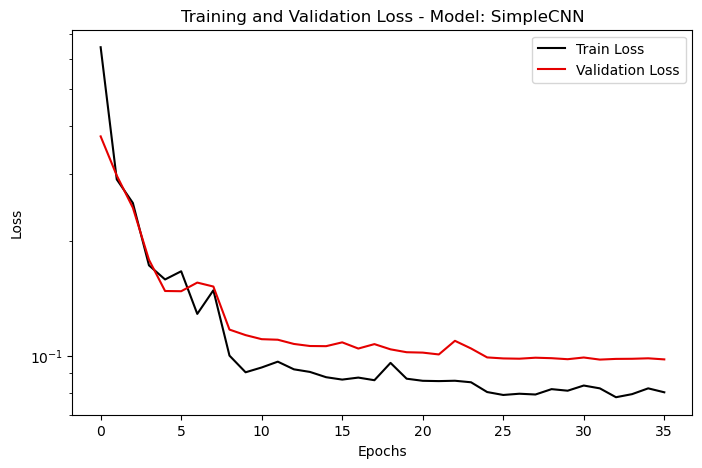

In [89]:
# # Load the model
# checkpoint = torch.load(f"{model_name}.pt")
# model = model.to(device) # move the model to the device
# model.load_state_dict(checkpoint['model_state_dict']) # load the model state dict
# optimizer.load_state_dict(checkpoint['optimizer_state_dict']) # load the optimizer state dict
# epoch = checkpoint['epoch'] # load the epoch
# loss = checkpoint['loss'] # load the loss
# validation_loss = checkpoint['validation_loss'] # load the validation loss
# print(f"Model loaded from {model_name}.pt")

# Test the model
model.eval() # The model should be in eval mode to not use batch normalization and dropout
test_loss = 0
with torch.no_grad(): # make sure the gradients are not changed in this step
    for batch_x, batch_y in test_loader:
        predictions = model(batch_x) # make a prediction with the current model
        loss = criterion(predictions, batch_y) # calculate the loss based on the prediction
        test_loss += loss.item() # calulate loss per batch
test_loss /= len(test_loader) # calculate total loss
print(f"Final Test Loss: {test_loss:.4f}")
# Plot training/validation loss
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss", color="black")
plt.plot(val_losses, label="Validation Loss", color="xkcd:red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.yscale("log")
plt.title("Training and Validation Loss - Model: "+model_name)
plt.legend()
plt.savefig(f'/Users/jonathan/Documents/Homeworks_with_Python/Adv. Deep Learning/Ex1_Astronomy/graphics/{model_name}_loss.png',bbox_inches='tight')

Correlation between predictions and labels:
[[0.98080425 0.55459149 0.18091584]
 [0.61199109 0.965725   0.44053273]
 [0.17648088 0.44547183 0.93560804]]


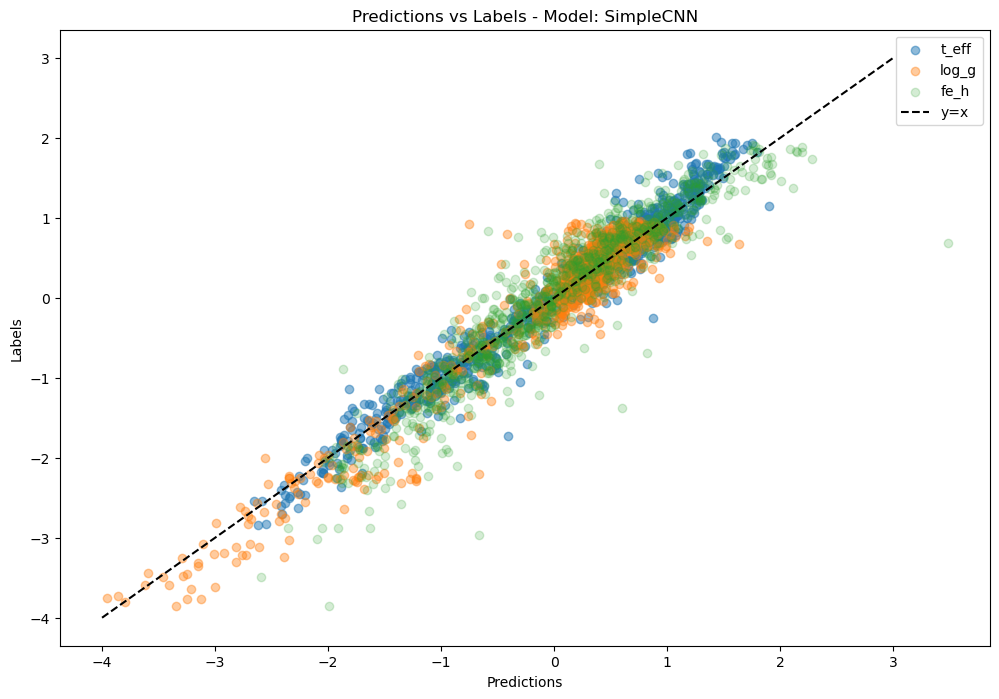

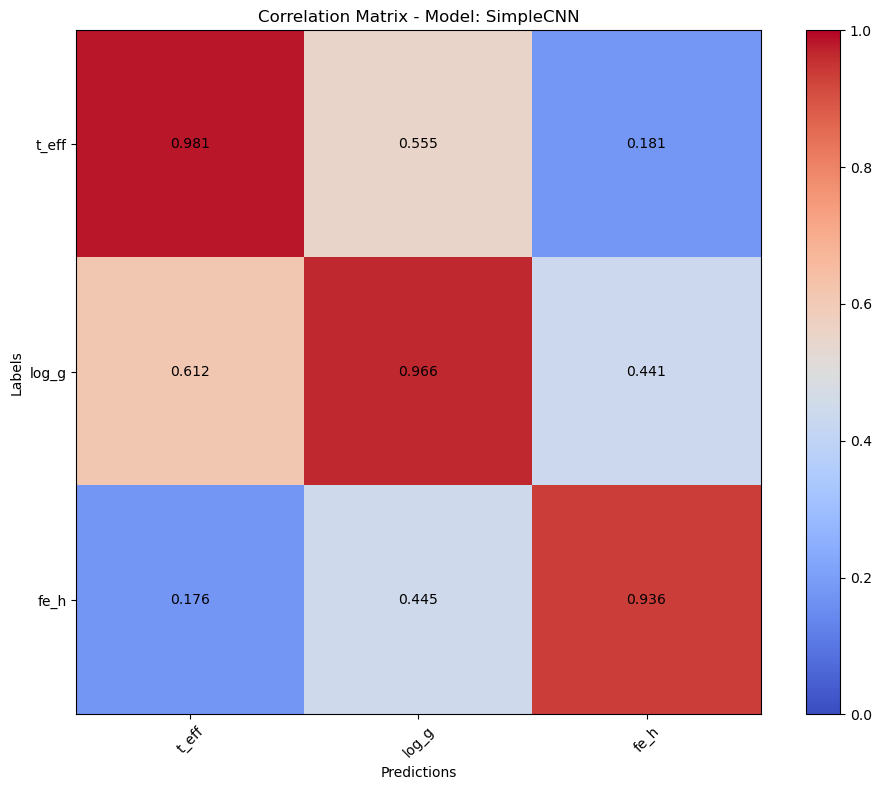

In [90]:
# Calculate the correlation between the predictions and the labels
predictions = []
labels = []
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        pred = model(batch_x)
        predictions.append(pred.cpu().numpy())
        labels.append(batch_y.cpu().numpy())
predictions = np.concatenate(predictions)
labels = np.concatenate(labels)
correlation = np.corrcoef(predictions.T, labels.T)[:3, 3:]
print("Correlation between predictions and labels:")
print(correlation)
# Plot the predictions vs labels
plt.figure(figsize=(12, 8))
plt.scatter(predictions[:, 0], labels[:, 0], label="t_eff", alpha=0.5)
plt.scatter(predictions[:, 1], labels[:, 1], label="log_g", alpha=0.4)
plt.scatter(predictions[:, 2], labels[:, 2], label="fe_h", alpha=0.2)
plt.plot([-4, 3], [-4, 3], color="black", linestyle="--", label="y=x")
plt.xlabel("Predictions")
plt.ylabel("Labels")
plt.title("Predictions vs Labels - Model: "+model_name)
plt.legend()
plt.savefig(f'/Users/jonathan/Documents/Homeworks_with_Python/Adv. Deep Learning/Ex1_Astronomy/graphics/{model_name}_predictions_vs_labels.png',bbox_inches='tight')

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
plt.imshow(correlation, cmap="coolwarm", vmin=0, vmax=1)
plt.colorbar()
# add text to the cells
for i in range(correlation.shape[0]):
    for j in range(correlation.shape[1]):
        plt.text(j, i, f"{correlation[i, j]:.3f}", ha="center", va="center", color="black")
plt.xticks(np.arange(3), labelNames, rotation=45)
plt.yticks(np.arange(3), labelNames)
plt.xlabel("Predictions")
plt.ylabel("Labels")
plt.title("Correlation Matrix - Model: "+model_name)
plt.tight_layout()
plt.savefig(f'/Users/jonathan/Documents/Homeworks_with_Python/Adv. Deep Learning/Ex1_Astronomy/graphics/{model_name}_correlation_matrix.png',bbox_inches='tight')

In [ ]:
#close the tensorboard writer
writer.flush()
writer.close()

#display the tensorboard interface
!tensorboard --logdir="runs/Gaia_CNN_model"
#open the browser and go to http://localhost:6006/ to see the tensorboard interface

TensorFlow installation not found - running with reduced feature set.
W0327 21:08:24.369446 6114160640 plugin_event_accumulator.py:369] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
W0327 21:08:24.371506 6114160640 plugin_event_accumulator.py:369] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
W0327 21:08:24.373636 6114160640 plugin_event_accumulator.py:369] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
W0327 21:08:24.376682 6114160640 plugin_event_accumulator.py:369] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the gra